In [1]:
# standard library
from functools import partial
import time

# third party
import numpy as np
import pandas as pd
from pymoo.indicators.hv import HV

# plot
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_theme()
# sklearn
from sklearn.preprocessing import LabelEncoder

# fairdo package
from fairdo.utils.dataset import load_data, dataset_intersectional_column
# everything needed for custom preprocessing
from fairdo.preprocessing import MultiObjectiveWrapper
from fairdo.optimize.multi import nsga2
from fairdo.optimize.geneticoperators import variable_initialization,\
    elitist_selection_multi,\
    onepoint_crossover,\
    bit_flip_mutation

# fairdo metrics
from fairdo.metrics import statistical_parity_abs_diff_max,\
    data_loss, group_missing_penalty,\
    statistical_parity_abs_diff_intersectionality

### 1. Load Dataset

In [2]:
data, label, protected_attributes = load_data('compas', multi_protected_attr=True)

Data downloaded.
[5 0 2 3 4 1]
0    3696
2    2454
3     637
5     377
1      32
4      18
Name: race, dtype: int64
(7214, 13)


### 2. Measure Intersectional Discrimination (2 Methods)

#### 2.1 Using Intersectional Metric

In [15]:
start = time.perf_counter()
method1 = statistical_parity_abs_diff_intersectionality(data[label].to_numpy(), data[protected_attributes].to_numpy())
elapsed = time.perf_counter() - start
print(elapsed)

0.049085863000073005


#### 2.2 Create new column containing intersectional groups

In [16]:
# Combine protected attributes to a single one
data, protected_attribute = dataset_intersectional_column(data, protected_attributes)
# Measure intersectional discrimination
start = time.perf_counter()
method2 = statistical_parity_abs_diff_max(data[label].to_numpy(), data[protected_attribute].to_numpy())
elapsed = time.perf_counter() - start
print(elapsed)

0.015573960001347587


In [18]:
np.abs(method1-method2)

0.0

### 3. Mitigate Bias for Intersectional Groups

In [6]:
def mitigate_intersectional_discrimination(pop_size=100, num_generations=100):
    # Setting up pre-processor (Best settings from previous experiment)
    ga = partial(nsga2,
                pop_size=pop_size,
                num_generations=num_generations,
                initialization=variable_initialization,
                selection=elitist_selection_multi,
                crossover=onepoint_crossover,
                mutation=bit_flip_mutation)

    preprocessor_multi = MultiObjectiveWrapper(heuristic=ga,
                                                   protected_attribute=protected_attribute,
                                                   label=label,
                                                   fitness_functions=[statistical_parity_abs_diff_max,
                                                                      data_loss])
    
    # Label encode the protected attribute
    le = LabelEncoder()
    data[protected_attribute] = le.fit_transform(data[protected_attribute])
    n_groups = data[protected_attribute].nunique()

    # Fit and transform the data, returns the data closest to the ideal solution
    preprocessor_multi.fit(dataset=data)
    data_multi = preprocessor_multi.transform(w=np.array([1, 1]))
    
    return preprocessor_multi

#### 3.1 Population = 50, Generation = 50

In [7]:
# Initialize HV calculation
ref_point = np.array([1.0, 1.0])
ind = HV(ref_point=ref_point)

start = time.perf_counter()
preprocessor_multi = mitigate_intersectional_discrimination(50, 50)
elapsed = time.perf_counter() - start
print(elapsed)

# Get Pareto front
pf = preprocessor_multi.get_pareto_front(return_baseline=False)
hv = ind(pf)

print(hv)

10.699362581999594
0.2304204126478655


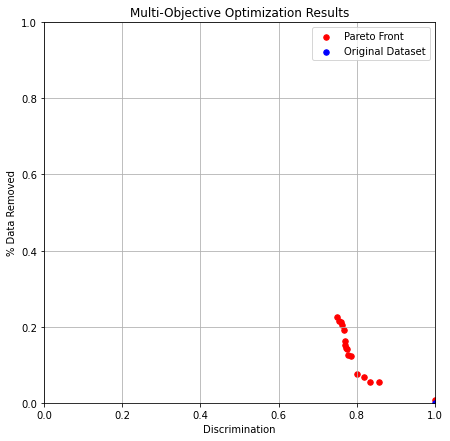

In [8]:
# Plot
preprocessor_multi.plot_results(xlabel='Discrimination', ylabel='% Data Removed')

#### 3.2 Population = 50, Generation = 100

In [9]:
start = time.perf_counter()
preprocessor_multi = mitigate_intersectional_discrimination(50, 100)
elapsed = time.perf_counter() - start
print(elapsed)

# Get Pareto front
pf = preprocessor_multi.get_pareto_front(return_baseline=False)
hv = ind(pf)

print(hv)

20.490864986000815
0.22682391100779373


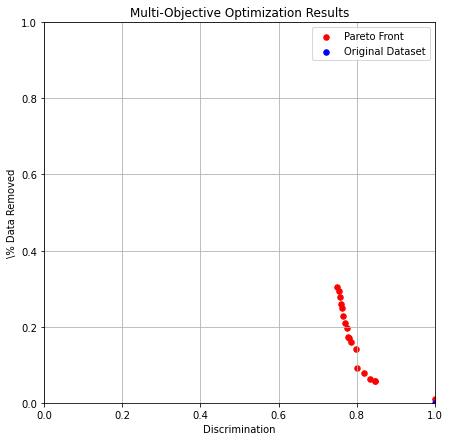

In [10]:
# Plot
preprocessor_multi.plot_results(xlabel='Discrimination', ylabel='\% Data Removed')

#### 3.3 Population = 100, Generation = 50

In [11]:
start = time.perf_counter()
preprocessor_multi = mitigate_intersectional_discrimination(100, 50)
elapsed = time.perf_counter() - start
print(elapsed)

# Get Pareto front
pf = preprocessor_multi.get_pareto_front(return_baseline=False)
hv = ind(pf)

print(hv)

21.012380056999973
0.251342813312849


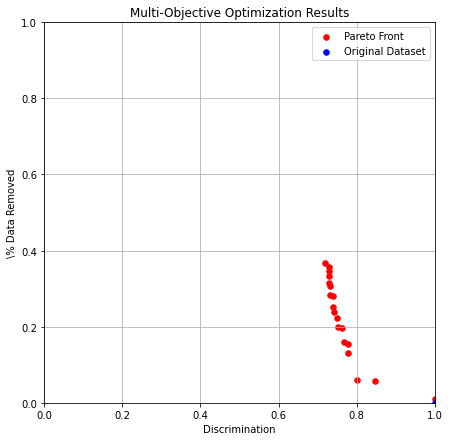

In [12]:
# Plot
preprocessor_multi.plot_results(xlabel='Discrimination', ylabel='\% Data Removed')

#### 3.4 Mitigating Bias (Slow version)

In [13]:
def mitigate_intersectional_discrimination_slow(pop_size=200, num_generations=200):
    # Setting up pre-processor (Best settings from previous experiment)
    ga = partial(nsga2,
                pop_size=pop_size,
                num_generations=num_generations,
                initialization=variable_initialization,
                selection=elitist_selection_multi,
                crossover=onepoint_crossover,
                mutation=bit_flip_mutation)

    preprocessor_multi = MultiObjectiveWrapper(heuristic=ga,
                                               protected_attribute=protected_attributes,
                                               label=label,
                                               fitness_functions=[statistical_parity_abs_diff_intersectionality,
                                                                  data_loss])

    # Fit and transform the data, returns the data closest to the ideal solution
    preprocessor_multi.fit(dataset=data)
    data_multi = preprocessor_multi.transform(w=np.array([1, 1]))
    
    return preprocessor_multi

89.77188758500051
0.2509793197091055


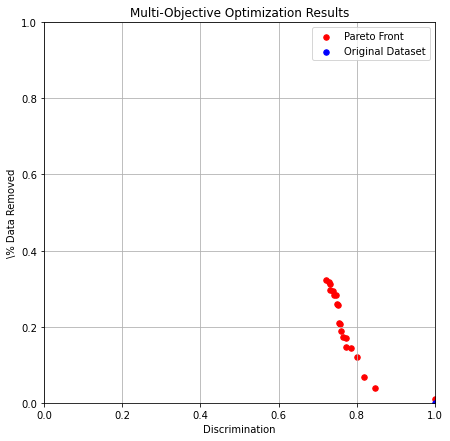

In [14]:
# Initialize HV calculation
ref_point = np.array([1.0, 1.0])
ind = HV(ref_point=ref_point)

start = time.perf_counter()
preprocessor_multi = mitigate_intersectional_discrimination_slow(100, 25)
elapsed = time.perf_counter() - start
print(elapsed)

# Get Pareto front
pf = preprocessor_multi.get_pareto_front(return_baseline=False)
hv = ind(pf)

print(hv)

# Plot
preprocessor_multi.plot_results(xlabel='Discrimination', ylabel='\% Data Removed')